# Методы bootstrap и jacknife для построения доверительных интервалов (оценки матожидания)

## Инструменты

In [19]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy import special
from tqdm import tqdm

In [2]:
def gen():
    return int(np.random.random() * 10**6)

In [14]:
def generator_uniform(n):
    return np.sort(np.random.uniform(-np.sqrt(3), np.sqrt(3), n))

def generator_normal(n):
    return np.sort(np.random.normal(0, 1, n))

def generator_exponential(n):
    return np.sort(stats.expon(scale=1, loc=-1).rvs(size=n, random_state=gen()))

generators_dict = dict(zip(['Uniform', 'Normal', 'Exponential'], [generator_uniform, generator_normal, generator_exponential]))

## Функции нахождения интервалов

In [63]:
def get_interval_jacknife(sample, q):
    n = sample.size

    m_total = sample.mean()
    m_s = np.array(
        [np.mean(np.delete(sample, i)) for i in range(n)]
    )
    m_s_mean = np.mean(m_s)
    se_jack = np.sqrt(
        (n / (n - 1)) * np.sum(
            [
                (item - m_s_mean) ** 2 for item in m_s
            ]
        )
    )

    return [
        m_total + special.stdtrit(n - 1, (1 - q) / 2) * se_jack,
        m_total + special.stdtrit(n - 1, (1 + q) / 2) * se_jack
    ]

def get_interval_bootstrap(sample, q, N=10**3):
    n = sample.size
    means = np.zeros(N)
    for i in range(N):
        bag_indices = np.random.randint(0, n, size=n)
        sub_sample = sample[bag_indices]

        means[i] = np.mean(sub_sample)
    return [
        np.quantile(means, (1 - q) / 2, method='nearest'),
        np.quantile(means, (1 + q) / 2, method='nearest')
    ]

get_intervals_dict = dict(zip(['Jacknife', 'Bootstrap'], [get_interval_jacknife, get_interval_bootstrap]))

## Функция оценки точности интервала

In [26]:
def calc_interval_probability(get_interval, generator, n, true_value, N=10**3):
    count_good = 0
    for _ in tqdm(range(N)):
        sample = generator(n)
        interval = get_interval(sample)

        if interval[0] <= true_value <= interval[1]:
            count_good += 1
    return count_good / N

In [24]:
def calc_interval_width(get_interval, generator, n, N=10**3):
    width_sum = 0
    for _ in tqdm(range(N)):
        sample = generator(n)
        interval = get_interval(sample)

        width_sum += interval[1] - interval[0]
    return width_sum / N

## Эксперименты

In [7]:
q = 0.95
np.random.seed(42)

### Доверительная вероятность

In [64]:
n_arange = np.array([100, 250, 500])

confidence_probs = {
    get_interval_func_name : {
        dist_name : np.vectorize(lambda n : calc_interval_probability(lambda sample : get_interval_func(sample, q), generator, n, 0))(n_arange)
        for dist_name, generator in generators_dict.items()
    } for get_interval_func_name, get_interval_func in get_intervals_dict.items()
}

100%|██████████| 1000/1000 [00:25<00:00, 39.86it/s]


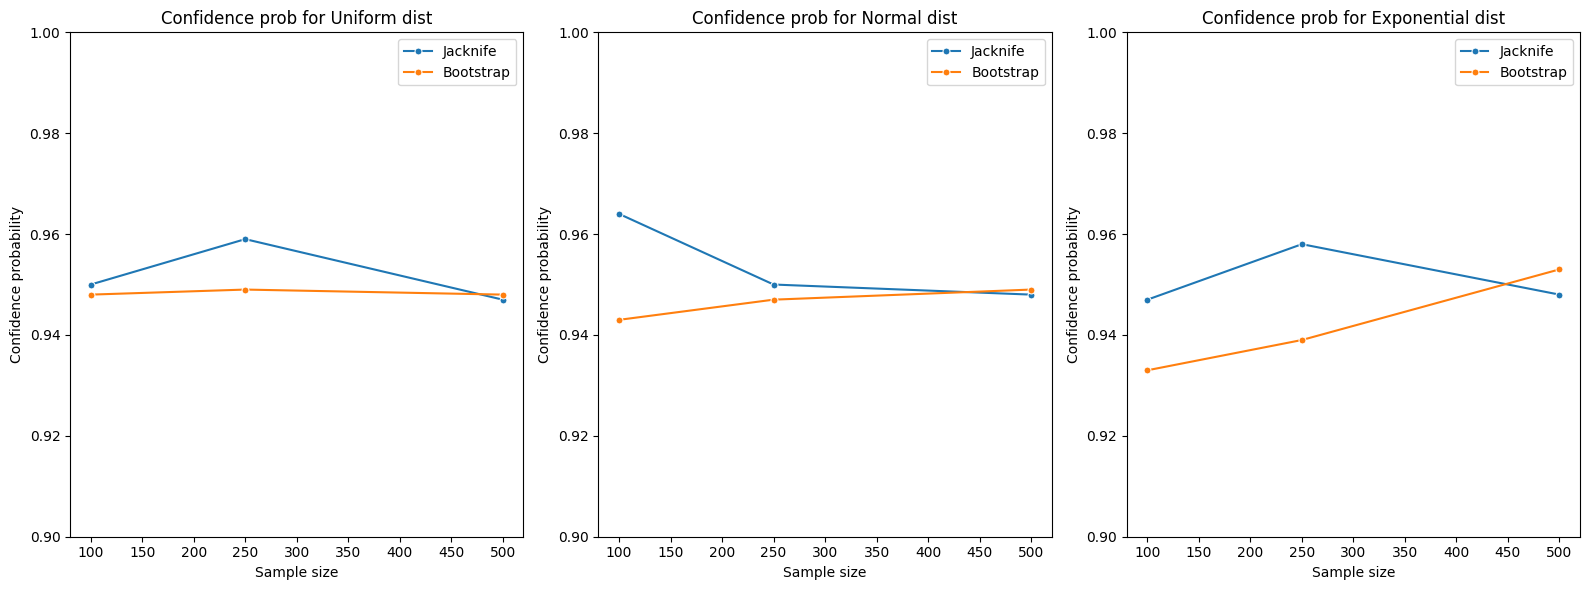

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

plt.title("Confidence probabilities for different distributions and methods")

for ax, dist_name in zip(axes, generators_dict.keys()):
    data_1 = pd.DataFrame({'x': n_arange, 'y': confidence_probs['Jacknife'][dist_name]})
    data_2 = pd.DataFrame({'x': n_arange, 'y': confidence_probs['Bootstrap'][dist_name]})

    sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='Jacknife', ax=ax)
    sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='Bootstrap', ax=ax)
    ax.set_title(f"Confidence prob for {dist_name} dist")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Confidence probability")

    ax.set_ylim(0.9, 1.)

plt.tight_layout()
plt.show();

### Ширина интервала

In [69]:
n_arange = np.array([100, 250, 500])

confidence_widths = {
    get_interval_func_name : {
        dist_name : np.vectorize(lambda n : calc_interval_width(lambda sample : get_interval_func(sample, q), generator, n))(n_arange)
        for dist_name, generator in generators_dict.items()
    } for get_interval_func_name, get_interval_func in get_intervals_dict.items()
}

100%|██████████| 1000/1000 [00:25<00:00, 39.29it/s]


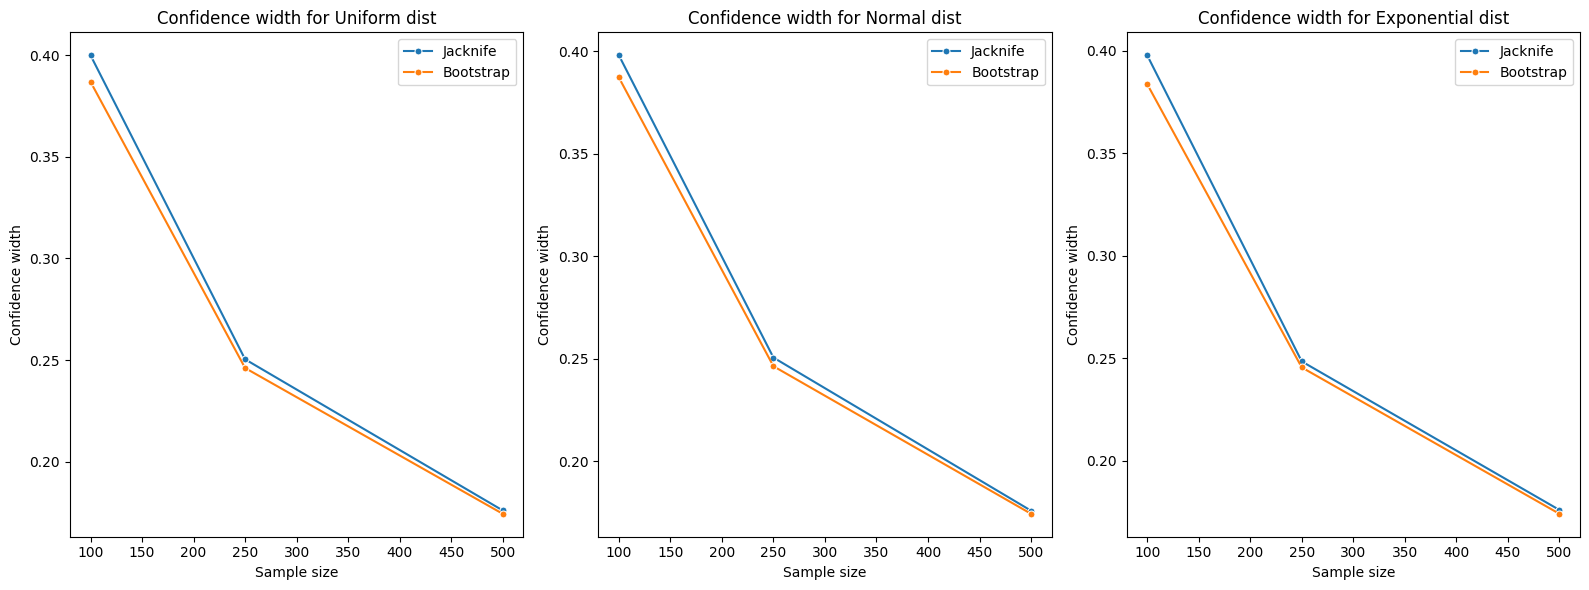

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

plt.title("Confidence widths for different distributions and methods")

for ax, dist_name in zip(axes, generators_dict.keys()):
    data_1 = pd.DataFrame({'x': n_arange, 'y': confidence_widths['Jacknife'][dist_name]})
    data_2 = pd.DataFrame({'x': n_arange, 'y': confidence_widths['Bootstrap'][dist_name]})

    sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='Jacknife', ax=ax)
    sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='Bootstrap', ax=ax)
    ax.set_title(f"Confidence width for {dist_name} dist")
    ax.set_xlabel("Sample size")
    ax.set_ylabel("Confidence width")

plt.tight_layout()
plt.show();